In [1]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = '/content/drive/MyDrive/Project  RUL'
evchargedata = os.path.join(path, 'evchargedata.csv')
evtripdata = os.path.join(path, 'evtripdata.csv')


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# --- Data Preparation and Feature Engineering ---

# Load the data
charge_data = pd.read_csv(evchargedata)
trip_data = pd.read_csv(evtripdata)

# Convert date columns to datetime objects
charge_data['BatteryChargeStartDate'] = pd.to_datetime(charge_data['BatteryChargeStartDate'])
charge_data['BatteryChargeStopDate'] = pd.to_datetime(charge_data['BatteryChargeStopDate'])
trip_data['TripStartDateTime'] = pd.to_datetime(trip_data['TripStartDateTime'])
trip_data['TripStopDateTime'] = pd.to_datetime(trip_data['TripStopDateTime'])

# --- Process Trip Data ---
# Sort trip data to correctly calculate cumulative sums
trip_data = trip_data.sort_values(by=['ParticipantID', 'TripStartDateTime']).reset_index(drop=True)
trip_data['CumulativeDistance_m'] = trip_data.groupby('ParticipantID')['TripDistance (m)'].cumsum()
trip_data['CumulativeEnergy_Wh'] = trip_data.groupby('ParticipantID')['Power Consumption (Wh)'].cumsum()

# Aggregate to daily max cumulative values
daily_trip_summary = trip_data.groupby([
    'ParticipantID',
    trip_data['TripStartDateTime'].dt.date
])[['CumulativeDistance_m', 'CumulativeEnergy_Wh']].max().reset_index()
daily_trip_summary = daily_trip_summary.rename(columns={'TripStartDateTime': 'Date'})

In [4]:
# --- Process Charge Data and Define SOH Proxy ---
# Calculate Charge Duration in minutes and SoC Change
charge_data['ChargeDuration_min'] = (charge_data['BatteryChargeStopDate'] - charge_data['BatteryChargeStartDate']).dt.total_seconds() / 60
charge_data['SoC_Change'] = charge_data['Ending SoC (of 12)'] - charge_data['Starting SoC (of 12)']

# Define SOH Proxy (Cycle Count)
charge_data['Cycle_Count'] = charge_data.groupby('ParticipantID').cumcount() + 1
charge_data['SOH_Proxy'] = charge_data['Cycle_Count']

# Aggregate by ParticipantID and Date (using Charge Start Date)
charge_data['Date'] = charge_data['BatteryChargeStartDate'].dt.date
daily_charge_summary = charge_data.groupby(['ParticipantID', 'Date']).agg(
    Avg_ChargeDuration=('ChargeDuration_min', 'mean'),
    Total_SoC_Change=('SoC_Change', 'sum'),
    Max_SOH_Proxy=('SOH_Proxy', 'max')
).reset_index()

# --- Final Dataset Merging ---
# Merge the daily summaries.
final_data = pd.merge(daily_charge_summary, daily_trip_summary, on=['ParticipantID', 'Date'], how='left')

# Drop missing trip data and sort
final_data = final_data.dropna().sort_values(by=['ParticipantID', 'Date']).reset_index(drop=True)

# Select final features and target
features = ['Avg_ChargeDuration', 'Total_SoC_Change', 'CumulativeDistance_m', 'CumulativeEnergy_Wh']
target = 'Max_SOH_Proxy'
data_for_rf = final_data[['ParticipantID', target] + features].copy()

print("--- Data Preparation Complete. Head of Final Dataset for RF ---")
print(data_for_rf.head())


--- Data Preparation Complete. Head of Final Dataset for RF ---
  ParticipantID  Max_SOH_Proxy  Avg_ChargeDuration  Total_SoC_Change  \
0          BL01             17               141.0                12   
1          BL01             22                92.8                 9   
2          BL01             23               208.0                 5   
3          BL01             24               662.0                 9   
4          BL01             26               330.0                10   

   CumulativeDistance_m  CumulativeEnergy_Wh  
0              414961.0              68288.0  
1              496931.0              79870.0  
2              560655.0              89166.0  
3              679513.0             105143.0  
4              784986.0             120934.0  


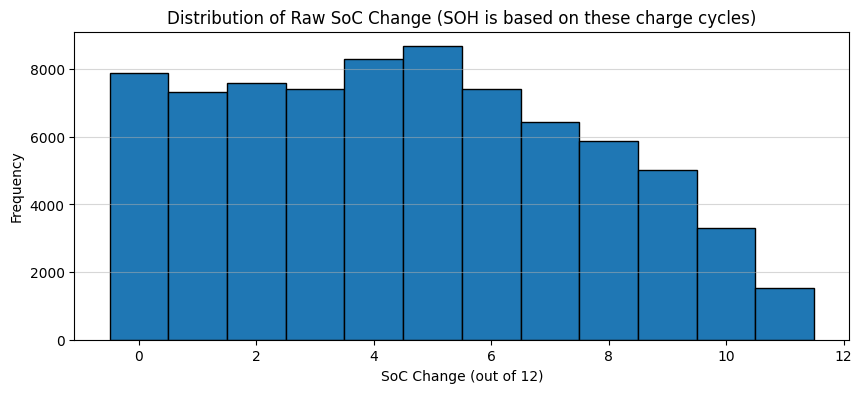

In [6]:
# --- Visualization of Raw & Processed Data ---
# Raw Data Visualization (Total SoC Change)
plt.figure(figsize=(10, 4))
plt.hist(charge_data['SoC_Change'], bins=np.arange(0, 13, 1), align='left', edgecolor='black')
plt.title('Distribution of Raw SoC Change (SOH is based on these charge cycles)')
plt.xlabel('SoC Change (out of 12)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()


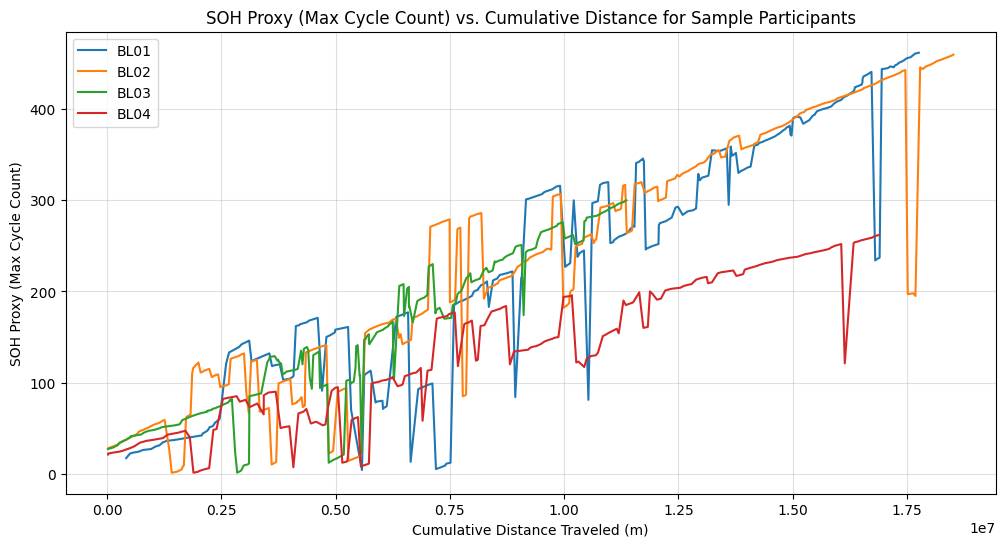

In [7]:
# Processed Data Visualization (SOH Proxy Degradation Trend)
sample_participants = data_for_rf['ParticipantID'].unique()[:4]
plt.figure(figsize=(12, 6))
for pid in sample_participants:
    subset = data_for_rf[data_for_rf['ParticipantID'] == pid]
    plt.plot(subset['CumulativeDistance_m'], subset['Max_SOH_Proxy'], label=pid)
plt.title('SOH Proxy (Max Cycle Count) vs. Cumulative Distance for Sample Participants')
plt.xlabel('Cumulative Distance Traveled (m)')
plt.ylabel('SOH Proxy (Max Cycle Count)')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [8]:
y = data_for_rf[target]

# The features (X) are the daily aggregated usage metrics
X = data_for_rf[features]

# We need to split the data while keeping the time-series nature in mind,
# although Random Forest itself doesn't inherently model time dependency.
# We will split based on the index to mimic a time-based split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

print(f"\nTraining Data Shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing Data Shape: X_test {X_test.shape}, y_test {y_test.shape}")



Training Data Shape: X_train (41004, 4), y_train (41004,)
Testing Data Shape: X_test (10252, 4), y_test (10252,)


In [9]:
# --- Random Forest Regression ---
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)


In [10]:
# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n## 📈 Random Forest Prediction Performance")
print(f"**R2 Score:** {r2:.4f} (Closer to 1.0 is better)")
print(f"**Mean Absolute Error (MAE):** {mae:.2f} Cycles (Average error in cycle prediction)")


## 📈 Random Forest Prediction Performance
**R2 Score:** 0.7161 (Closer to 1.0 is better)
**Mean Absolute Error (MAE):** 44.71 Cycles (Average error in cycle prediction)


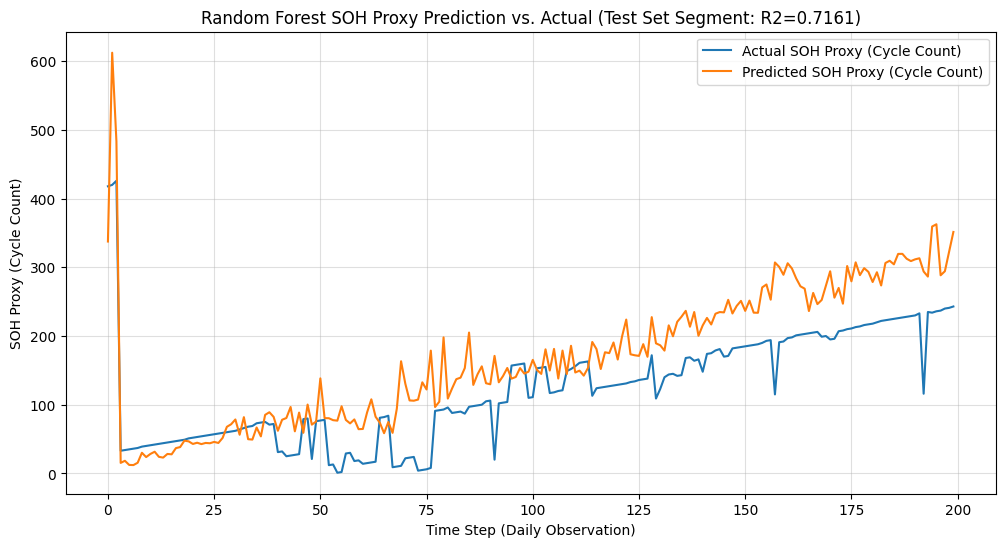

In [11]:
# Results Visualization
plt.figure(figsize=(12, 6))
# Only plot a segment of the test set for clarity, as it's a long time series
segment_length = 200
plt.plot(y_test.values[:segment_length], label='Actual SOH Proxy (Cycle Count)')
plt.plot(y_pred[:segment_length], label='Predicted SOH Proxy (Cycle Count)')
plt.title(f'Random Forest SOH Proxy Prediction vs. Actual (Test Set Segment: R2={r2:.4f})')
plt.xlabel('Time Step (Daily Observation)')
plt.ylabel('SOH Proxy (Cycle Count)')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

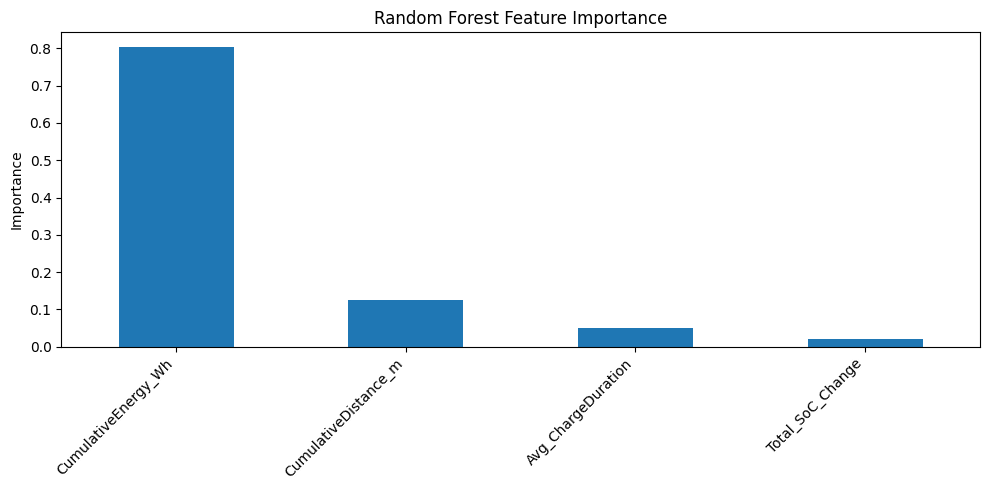


--- Feature Importance ---
CumulativeEnergy_Wh     0.802965
CumulativeDistance_m    0.123945
Avg_ChargeDuration      0.051440
Total_SoC_Change        0.021650
dtype: float64


In [12]:
# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
feature_importances.plot(kind='bar')
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- Feature Importance ---")
print(feature_importances)